In [3]:
# ==============================
# 1. DATA & VISUALIZATION
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 2. ML & PREPROCESSING
# ==============================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# ==============================
# 3. MODELS
# ==============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# ==============================
# 4. METRICS
# ==============================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# ==============================
# 5. IMBALANCE HANDLING
# ==============================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ==============================
# 6. UTILITIES
# ==============================
import joblib
import warnings
warnings.filterwarnings("ignore")


In [4]:
# LOAD DATA
df = pd.read_csv("../Loan_default_prediction.csv")

df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


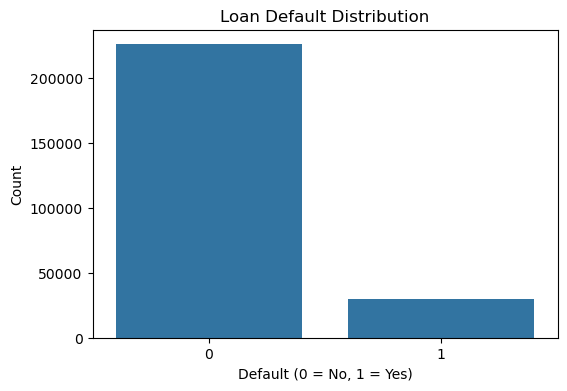

Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64

In [5]:
#TARGET DISTRIBUTION (EDA)

plt.figure(figsize=(6,4))
sns.countplot(x=df["Default"].astype(str))
plt.title("Loan Default Distribution")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

df["Default"].value_counts(normalize=True) * 100


In [6]:
#Observation (Report):

#The dataset is highly imbalanced, with only ~11.6% default cases. 
#This necessitates SMOTE, class-weighting, and recall-focused evaluation.

In [7]:
#FEATURE / TARGET SPLIT

X = df.drop(columns=["LoanID", "Default"])
y = df["Default"]


In [8]:
# COLUMN TYPES
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

LOW_CARD_THRESHOLD = 10

low_card_cols = [c for c in categorical_cols if X[c].nunique() <= LOW_CARD_THRESHOLD]
high_card_cols = [c for c in categorical_cols if X[c].nunique() > LOW_CARD_THRESHOLD]



In [9]:
# PREPROCESSING PIPELINES
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

low_cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

high_cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# COMBINE ALL
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_cols),
    ("low_cat", low_cat_pipeline, low_card_cols),
    ("high_cat", high_cat_pipeline, high_card_cols)
])


In [10]:
# Numeric: median imputation + scaling
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Low-cardinality categorical: One-Hot (dense output)
low_cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# High-cardinality categorical: Ordinal Encoding
high_cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Combine all
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_cols),
    ("low_cat", low_cat_pipeline, low_card_cols),   # <- use low_card_cols
    ("high_cat", high_cat_pipeline, high_card_cols) # <- use high_card_cols
])



In [11]:
# TRAIN / TEST SPLIT 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [12]:
#MODELS

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=80,
        max_depth=12,
        min_samples_leaf=10,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    ),
    "Linear SVM": LinearSVC(
        max_iter=2000,
        class_weight="balanced"
    ),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=300,
        random_state=42
    )
}


In [13]:
#pipelines 
pipelines = {}

for name, model in models.items():
    pipelines[name] = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])


Training Logistic Regression...


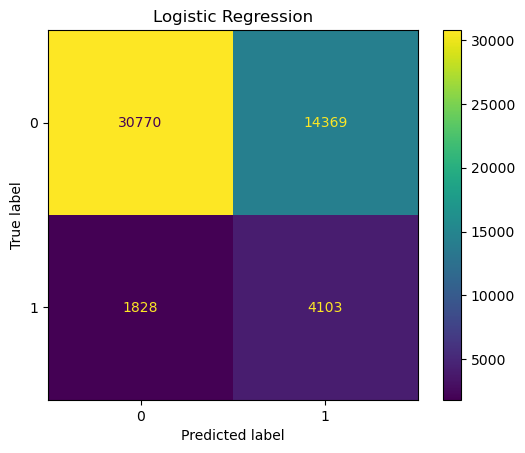

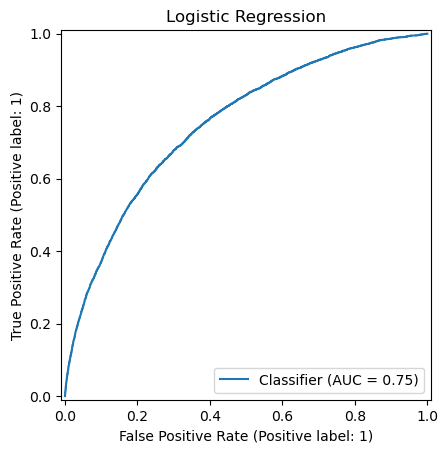

Training Random Forest...


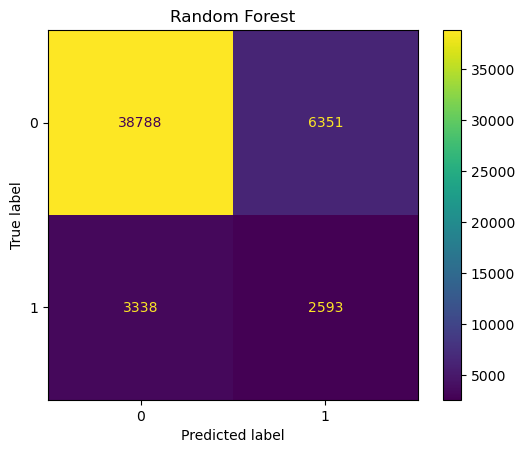

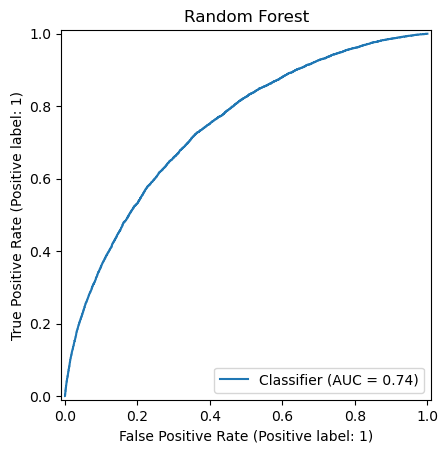

Training Linear SVM...


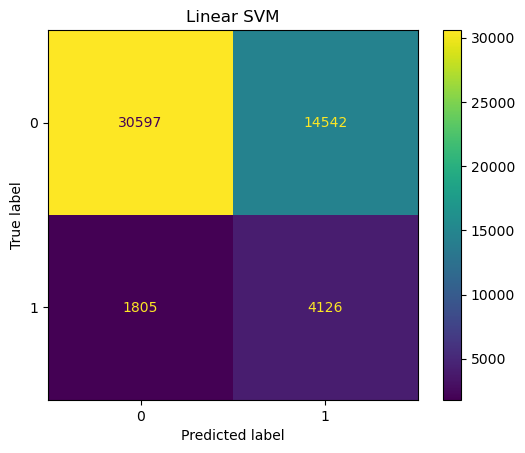

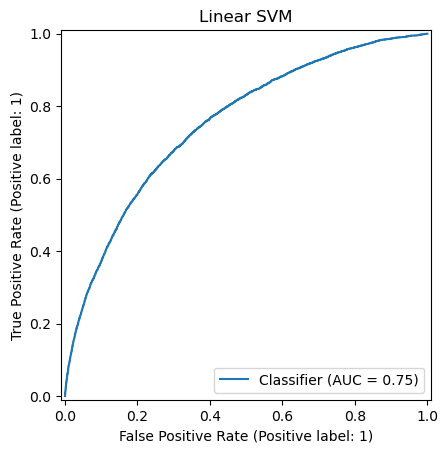

Training Neural Network (MLP)...


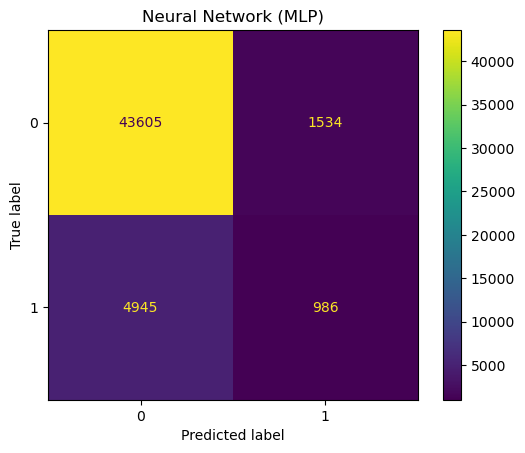

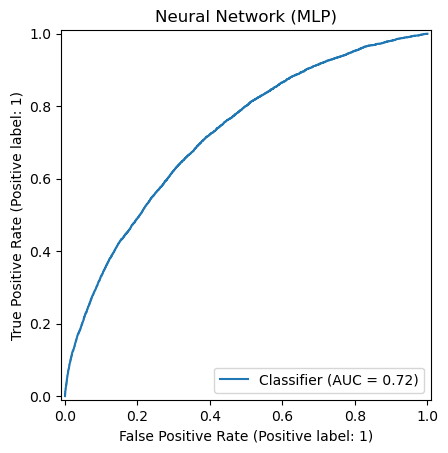

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.682847,0.222120,0.691789,0.336270,0.753130
1,Random Forest,0.810280,0.289915,0.437194,0.348639,0.744424
2,Linear SVM,0.679910,0.221020,0.695667,0.335461,0.753176
3,Neural Network (MLP),0.873135,0.391270,0.166245,0.233345,0.723377


In [14]:
#metrics
metrics = []

for name, pipe in pipelines.items():
    print(f"Training {name}...")

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    model_obj = pipe.named_steps["model"]
    if hasattr(model_obj, "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:,1]
    else:
        scores = pipe.decision_function(X_test)
        y_score = (scores - scores.min()) / (scores.max() - scores.min())

    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_score)
    })

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(name)
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_score)
    plt.title(name)
    plt.show()

    joblib.dump(pipe, f"../web_app/models/{name.lower().replace(' ', '_')}_model.pkl")

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../web_app/model_metrics.csv", index=False)
metrics_df


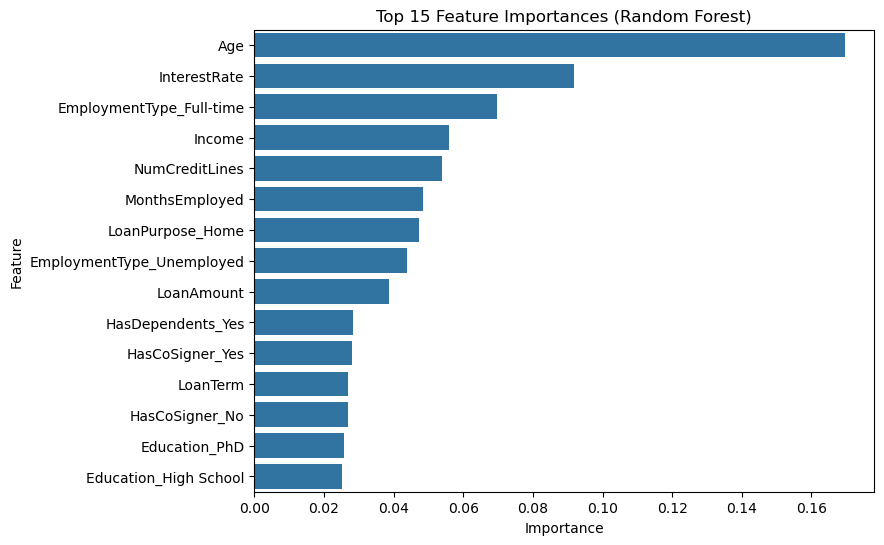

In [15]:
# Reconstruct feature names
feature_names = np.concatenate([
    numerical_cols,
    pipelines["Random Forest"]
        .named_steps["preprocessor"]
        .named_transformers_["low_cat"]
        .named_steps["encoder"]
        .get_feature_names_out(low_card_cols),
    high_card_cols
])

rf = pipelines["Random Forest"].named_steps["model"]

rf_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    data=rf_importance.head(15),
    x="Importance",
    y="Feature"
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()
